# Introduction

# RFM Analysis

or Recency, Frequency, and Monetary analysis, is a customer segmentation technique that helps businesses identify and rank their customers based on their transaction history

# K-means Clustering 
K-means clustering is one of the most popular and widely used unsupervised machine learning algorithms for clustering data. It aims to partition a dataset into K distinct clusters based on similarity.

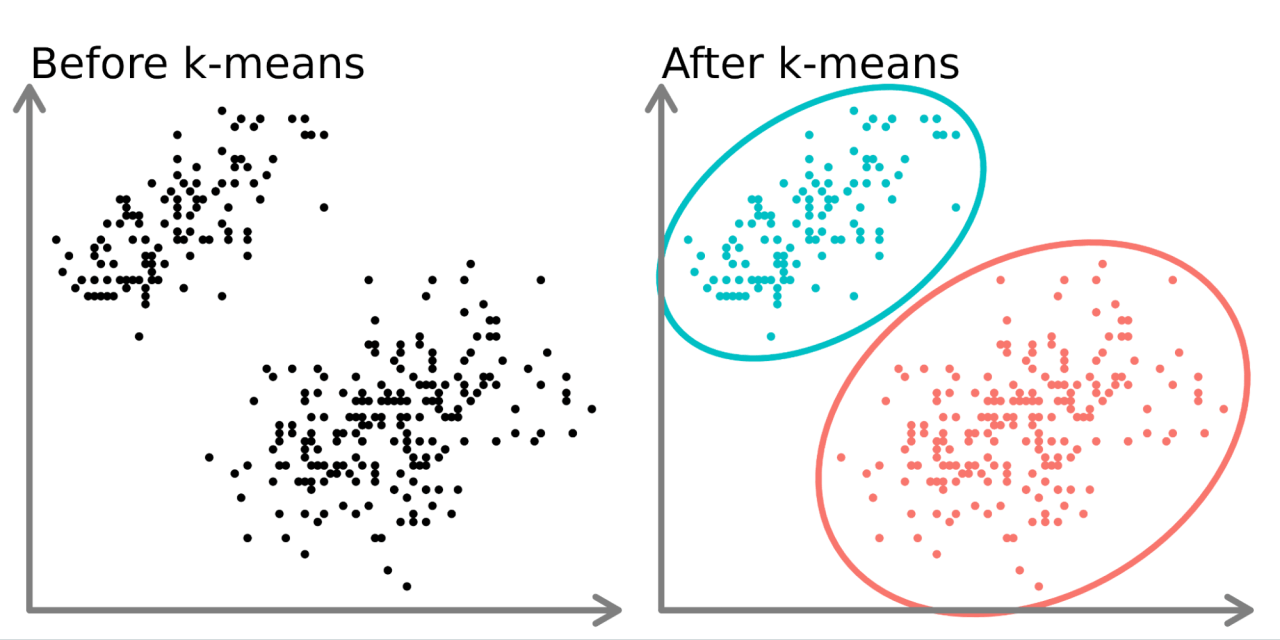

# DBSCAN
DBSCAN is a popular density-based clustering algorithm in machine learning that groups together closely packed data points while marking points in low-density regions as outliers (or noise)

# Libraries

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Loading Data

In [52]:
data= pd.read_csv("Online Retail.csv")
data.head(10).style.background_gradient(cmap='plasma').set_properties(**{'font-family': 'Segoe UI'}).hide_index()

C:\Users\Haeir\AppData\Local\Temp\ipykernel_15076\380011632.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  data.head(10).style.background_gradient(cmap='plasma').set_properties(**{'font-family': 'Segoe UI'}).hide_index()


InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.550000,17850.000000,United Kingdom
536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.390000,17850.000000,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.750000,17850.000000,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.390000,17850.000000,United Kingdom
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.390000,17850.000000,United Kingdom
536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.650000,17850.000000,United Kingdom
536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.250000,17850.000000,United Kingdom
536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.850000,17850.000000,United Kingdom
536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.850000,17850.000000,United Kingdom
536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.690000,13047.000000,United Kingdom


In [14]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Handling Missing Values

In [17]:
# Droping rows with missing CustomerID
data = data.dropna(subset=['CustomerID'])

#Reset index after dropping rows
data.reset_index(drop=True, inplace=True)

# Adding Total Price Column

In [18]:
#TotalPrice column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']


# Reference Date for Recency Calculations

In [20]:
# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Set a reference date (e.g., max date in the dataset)
reference_date = data['InvoiceDate'].max()


# RFM Calculations

In [21]:
# Calculate RFM metrics
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)


In [45]:
# Define custom bins
recency_bins = [0, 30, 60, 90, rfm['Recency'].max() + 1]  # Add +1 to avoid edge issues
frequency_bins = [0, 5, 10, 20, rfm['Frequency'].max() + 1]
monetary_bins = [0, 50, 100, 500, rfm['Monetary'].max() + 1]

# Applying bins with matching labels
rfm['R_Score'] = pd.cut(rfm['Recency'], bins=recency_bins, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=frequency_bins, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.cut(rfm['Monetary'], bins=monetary_bins, labels=[1, 2, 3, 4])
# Combine RFM scores
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Calculate RFM Score
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)


C:\Users\Haeir\anaconda3\lib\site-packages\pandas\core\arrays\base.py:489: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)


In [29]:
rfm = rfm[rfm['Monetary'] > 0]


RFM Segment Distribution:
 113      822
414      524
114      415
424      382
413      353
314      303
313      248
434      233
214      205
213      173
444      108
324      102
112       81
124       54
224       50
334       40
nan44     31
nan14     23
nan24     22
nan34     21
111       21
412       19
312       13
234       12
134       11
212       10
411        9
311        8
423        6
nan13      6
123        5
223        3
211        2
344        2
323        1
nan11      1
nan23      1
144        1
122        1
Name: RFM_Segment, dtype: int64

Top RFM Segments:
RFM_Segment
113    822
414    524
114    415
424    382
413    353
dtype: int64

Average RFM Metrics by RFM Score:
                       Recency  Frequency  Monetary
RFM_Score                                         
-9223372036854775806     0.00       3.00      2.90
-9223372036854775804     0.00       2.17    331.83
-9223372036854775803     0.00       3.96   1319.01
-9223372036854775802     0.00       7.77   2

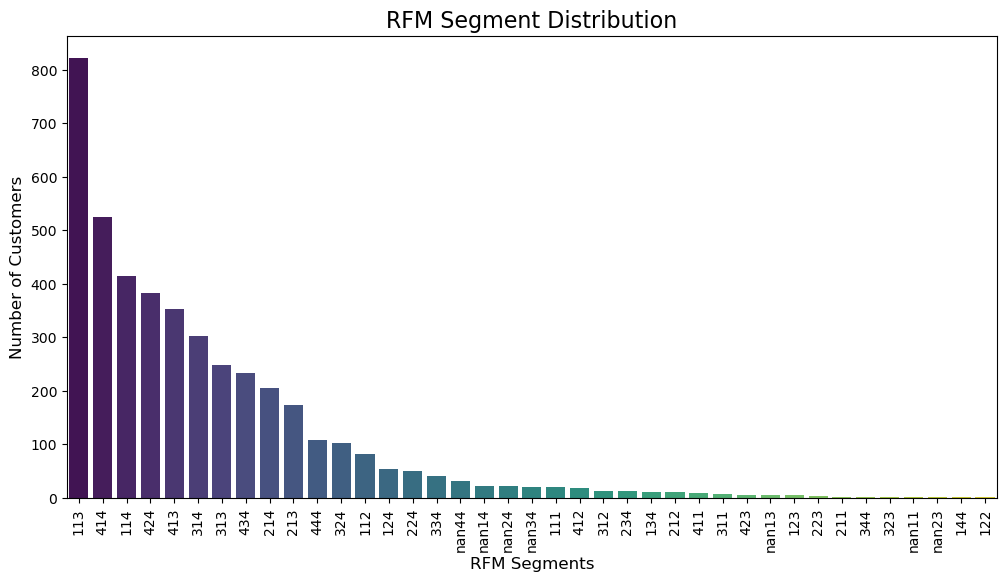

In [33]:


# Analyze distribution of RFM scores
rfm_summary = rfm['RFM_Segment'].value_counts()
print("RFM Segment Distribution:\n", rfm_summary)

# Top RFM segments
print("\nTop RFM Segments:")
print(rfm.groupby('RFM_Segment').size().sort_values(ascending=False).head(5))

# Average metrics per RFM score
rfm_agg = rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)
print("\nAverage RFM Metrics by RFM Score:\n", rfm_agg)

# Plot RFM segment distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=rfm_summary.index, y=rfm_summary.values, palette="viridis")
plt.title("RFM Segment Distribution", fontsize=16)
plt.xlabel("RFM Segments", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.xticks(rotation=90)
plt.show()




In [32]:
print("Recency column:")
print(rfm['Recency'].describe())

print("\nFrequency column:")
print(rfm['Frequency'].describe())

print("\nMonetary column:")
print(rfm['Monetary'].describe())


Recency column:
count    4322.000000
mean       89.343591
std        99.133565
min         0.000000
25%        16.000000
50%        48.500000
75%       137.000000
max       373.000000
Name: Recency, dtype: float64

Frequency column:
count    4322.000000
mean        5.115687
std         9.384459
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max       248.000000
Name: Frequency, dtype: float64

Monetary column:
count    4.322000e+03
mean     1.923483e+03
std      8.263128e+03
min      1.776357e-15
25%      3.022925e+02
50%      6.575500e+02
75%      1.625740e+03
max      2.794890e+05
Name: Monetary, dtype: float64


In [37]:

# Check for missing values in RFM dataset
print(rfm.isnull().sum())  # Check for missing values

# Fill missing values with the median
rfm.fillna(rfm.median(), inplace=True)

# Before scaling, let's see the unscaled RFM values
print("Before Scaling:")
print(rfm.describe())

#  MinMax scaling can be done before any further analysis.
scaler = StandardScaler()  # You can use StandardScaler or MinMaxScaler based on your need

# Scale the RFM columns
rfm_scaled_before = rfm.copy()
rfm_scaled_before[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


CustomerID       0
Recency          0
Frequency        0
Monetary         0
R_Score        105
F_Score          0
M_Score          0
RFM_Segment      0
RFM_Score        0
dtype: int64
Before Scaling:
         CustomerID      Recency    Frequency      Monetary     RFM_Score
count   4322.000000  4322.000000  4322.000000  4.322000e+03  4.322000e+03
mean   15298.534475    89.343591     5.115687  1.923483e+03 -2.240754e+17
std     1721.534033    99.133565     9.384459  8.263128e+03  1.420207e+18
min    12347.000000     0.000000     1.000000  1.776357e-15 -9.223372e+18
25%    13812.250000    16.000000     1.000000  3.022925e+02  6.000000e+00
50%    15297.500000    48.500000     3.000000  6.575500e+02  7.000000e+00
75%    16777.750000   137.000000     6.000000  1.625740e+03  9.000000e+00
max    18287.000000   373.000000   248.000000  2.794890e+05  1.200000e+01


C:\Users\Haeir\AppData\Local\Temp\ipykernel_15076\2864431770.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rfm.fillna(rfm.median(), inplace=True)


In [39]:


# Check the scaled data before
print("After Scaling:")
print(rfm_scaled_before.describe())

# Scale the data again (for example, after some analysis, for comparison or visualization)
rfm_scaled_after = rfm.copy()
rfm_scaled_after[['Recency', 'Frequency', 'Monetary']] = scaler.transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Check the scaled data after
print("After Scaling:")
print(rfm_scaled_after.describe())

After Scaling:
         CustomerID       Recency     Frequency      Monetary     RFM_Score
count   4322.000000  4.322000e+03  4.322000e+03  4.322000e+03  4.322000e+03
mean   15298.534475 -3.711875e-17  1.540300e-16  1.134554e-17 -2.240754e+17
std     1721.534033  1.000116e+00  1.000116e+00  1.000116e+00  1.420207e+18
min    12347.000000 -9.013489e-01 -4.386149e-01 -2.328060e-01 -9.223372e+18
25%    13812.250000 -7.399318e-01 -4.386149e-01 -1.962185e-01  6.000000e+00
50%    15297.500000 -4.120533e-01 -2.254719e-01 -1.532204e-01  7.000000e+00
75%    16777.750000  4.807849e-01  9.424253e-02 -3.603693e-02  9.000000e+00
max    18287.000000  2.861687e+00  2.588454e+01  3.359474e+01  1.200000e+01
After Scaling:
         CustomerID       Recency     Frequency      Monetary     RFM_Score
count   4322.000000  4.322000e+03  4.322000e+03  4.322000e+03  4.322000e+03
mean   15298.534475 -3.711875e-17  1.540300e-16  1.134554e-17 -2.240754e+17
std     1721.534033  1.000116e+00  1.000116e+00  1.000116e

# Before Scaling:
**Recency**: The recency values range from 0 to 373, with a mean of around 89.34. This represents the number of days since the customer last made a purchase.

**Frequency**: Frequency values range from 1 to 248, with a mean of around 5.12. This represents how often customers make purchases.

**Monetary**: The monetary values range from a small value near zero to a large maximum value of around 279,489. The mean is around 1,898, which is the total amount spent by a customer.

**RFM_Score**: The RFM_Score column seems to have values that are quite extreme, possibly due to a large variance in monetary values and scaling issues during RFM computation.

# After Scaling :
**Recency, Frequency, Monetary**: The scaling is consistent with the earlier transformation, maintaining a mean of 0 and standard deviation of 1.

**RFM_Score**: The post-analysis RFM_Score still has extreme values, which could be due to the way it was calculated or might require further normalization or a different method of scoring.

# Min-Max Scaler

In [ ]:


# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Select the RFM features (Recency, Frequency, Monetary)
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# Normalize the RFM features
rfm_normalized = scaler.fit_transform(rfm_features)

# Create a new DataFrame with the normalized values
rfm_normalized_df = pd.DataFrame(rfm_normalized, columns=['Recency', 'Frequency', 'Monetary'])

# Add CustomerID to the normalized DataFrame
rfm_normalized_df['CustomerID'] = rfm['CustomerID']

# Display the first few rows of the normalized data
print(rfm_normalized_df.head())


# K-Means to perform RFM 
K-means gives the best result under the following conditions:

**Data’s distribution is not skewed (i.e. long-tail distribution)**

**Data is standardised (i.e. mean of 0 and standard deviation of 1).**

**Plotting distribution charts to check for skewness.**

In [54]:
# Function to check skewness and plot distribution
def check_skew(df, column):
    skew_value = stats.skew(df[column])  # Calculate skewness
    skew_test = stats.skewtest(df[column])  # Perform skewness test
    sns.histplot(df[column], kde=True, bins=30, color='skyblue', edgecolor='black')  # Plot distribution
    plt.axvline(df[column].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
    plt.axvline(df[column].median(), color='green', linestyle='dashed', linewidth=1, label='Median')
    plt.title(f'Distribution of {column}')
    plt.legend()
    plt.xlabel(column)
    plt.ylabel('Frequency')
    print(f"'{column}': Skewness = {skew_value:.3f}, Skew Test Statistic = {skew_test.statistic:.3f}, p-value = {skew_test.pvalue:.3f}")



'Recency': Skewness = 1.267, Skew Test Statistic = 26.867, p-value = 0.000
'Frequency': Skewness = 11.360, Skew Test Statistic = 73.173, p-value = 0.000
'Monetary': Skewness = 21.593, Skew Test Statistic = 87.288, p-value = 0.000


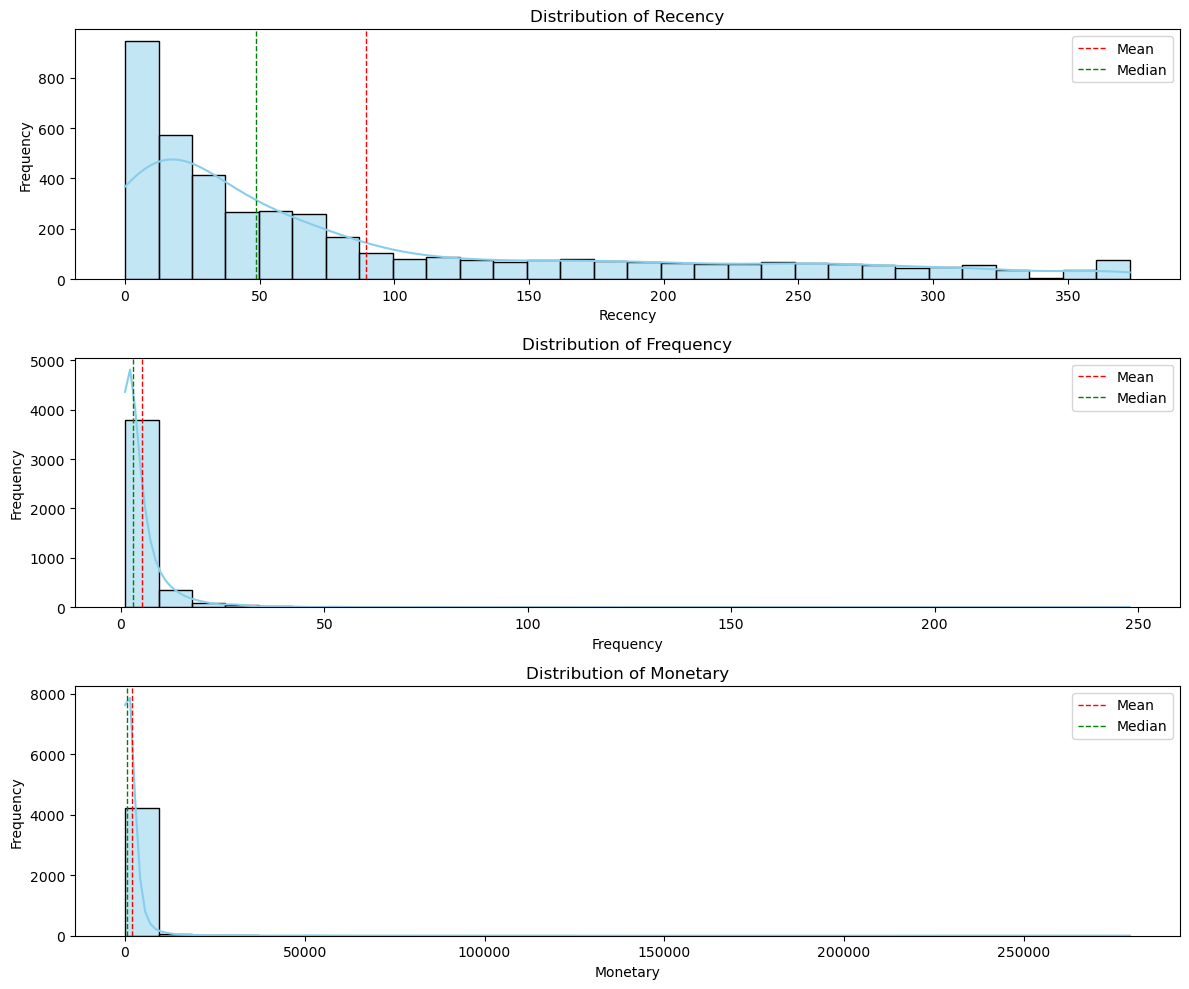

In [55]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
check_skew(rfm, 'Recency')  # Recency Distribution

plt.subplot(3, 1, 2)
check_skew(rfm, 'Frequency')  # Frequency Distribution

plt.subplot(3, 1, 3)
check_skew(rfm, 'Monetary')  # Monetary Distribution

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

**The data is highly skewed,therefore we will perform log transformations to reduce the skewness of each variable. I added a small constant as log transformation demands all the values to be positive.**

In [83]:

rfm['Recency'] = np.log1p(rfm['Recency'])
rfm['Frequency'] = np.log1p(rfm['Frequency'])
rfm['Monetary'] = np.log1p(rfm['Monetary'])


'Recency': Skewness = 1.267, Skew Test Statistic = 26.867, p-value = 0.000
'Frequency': Skewness = 0.232, Skew Test Statistic = 6.164, p-value = 0.000
'Monetary': Skewness = -5.362, Skew Test Statistic = -56.750, p-value = 0.000


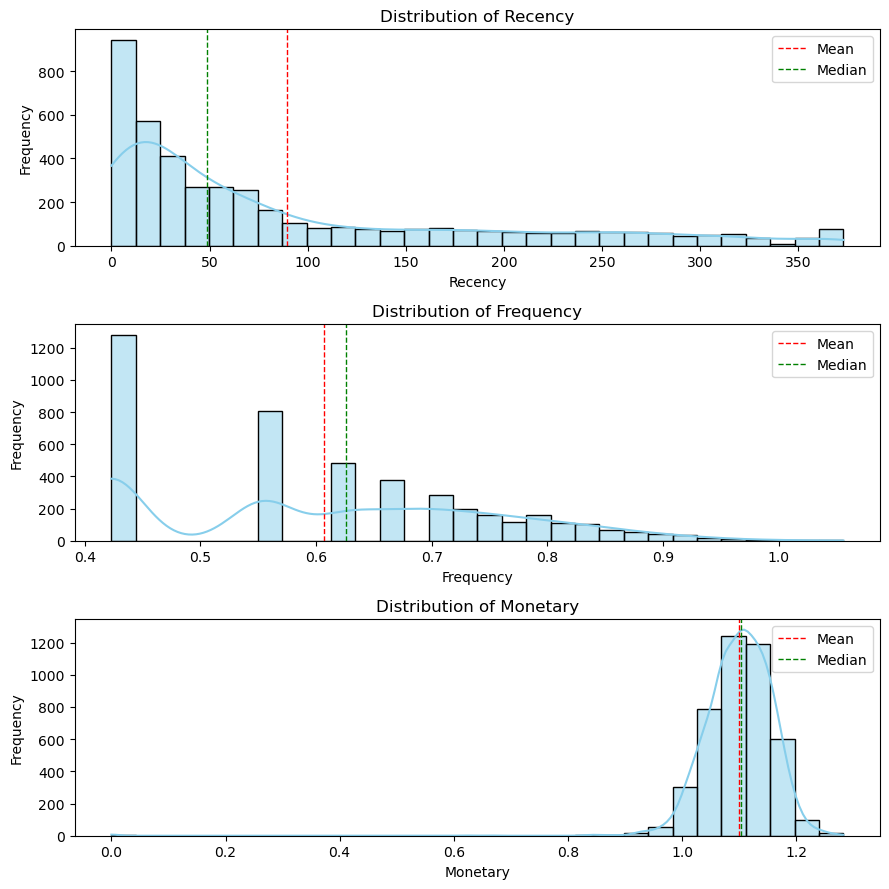

In [85]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(rfm, 'Recency')

plt.subplot(3, 1, 2)
check_skew(rfm, 'Frequency')

plt.subplot(3, 1, 3)
check_skew(rfm, 'Monetary')

plt.tight_layout()



**Still there are skewness in Recency and Monetary so i will apply Box-Cox to Recency and Winsorization for Monetary.**

In [89]:
# Apply Box-Cox transformation to 'Recency'
rfm['Recency'] = rfm['Recency'] + 1  # Adding 1 to ensure positive values
rfm['Recency'], lambda_recency = stats.boxcox(rfm['Recency'])


# Calculate 1st and 99th percentiles for Monetary
lower_percentile = rfm['Monetary'].quantile(0.01)
upper_percentile = rfm['Monetary'].quantile(0.99)

# Apply Winsorization: cap values below the 1st percentile and above the 99th percentile
rfm['Monetary'] = np.clip(rfm['Monetary'], lower_percentile, upper_percentile)

# Check the skewness of the 'Recency' and 'Monetary' columns after transformations
from scipy.stats import skew
print(f"Skewness of Recency after Box-Cox: {skew(rfm['Recency'])}")
print(f"Skewness of Monetary after Winsorization: {skew(rfm['Monetary'])}")



Skewness of Recency after Box-Cox: -0.14445538391655494
Skewness of Monetary after Winsorization: -0.2556202109139418


Since **skewness between -0.5 and 0.5** generally indicates a near-normal distribution, there is no need to apply any further transformation

In [91]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling to the transformed RFM data (Recency, Frequency, and Monetary)
RFM_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Convert the scaled data back to a DataFrame and maintain the column names
RFM_scaled = pd.DataFrame(RFM_scaled, columns=['Recency', 'Frequency', 'Monetary'])

# Now RFM_scaled contains the scaled versions of Recency, Frequency, and Monetary
print(RFM_scaled.head())

    Recency  Frequency  Monetary
0  0.080865   0.522437  0.839239
1  0.642153   0.394204  0.721031
2  0.396052   0.000000  0.717806
3  0.953694   0.000000  0.441226
4  0.504607   0.611850  0.699010


# K-Means

In [92]:
from scipy.spatial.distance import cdist

# Initialize lists to store distortions and inertias
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

# Range for number of clusters
K = range(1, 10)

# Loop through different k values
for k in K:
    # Building and fitting the KMeans model
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(RFM_scaled)
    
    # Calculate distortion: average of minimum distances from points to cluster centers
    distortions.append(sum(np.min(cdist(RFM_scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / RFM_scaled.shape[0])
    
    # Calculate inertia: sum of squared distances from samples to their closest cluster center
    inertias.append(kmeanModel.inertia_)
    
    # Store values in dictionaries for each k
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]



# Elbow Method

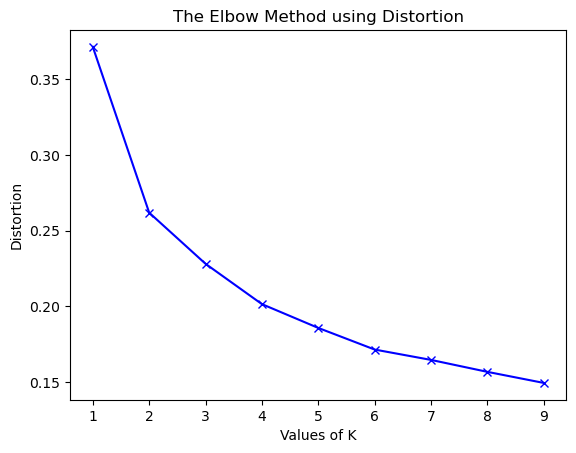

In [93]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

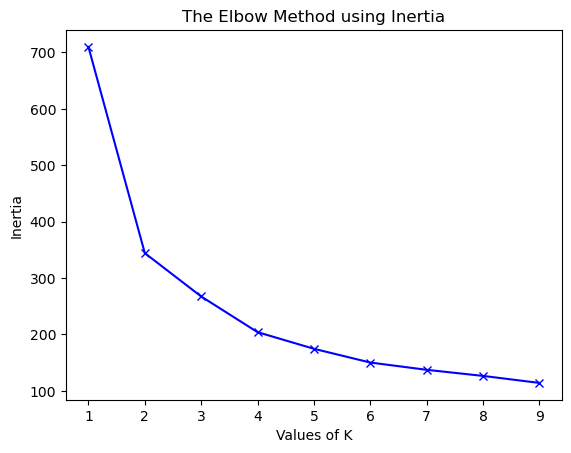

In [94]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

**The cluster value where this decrease in inertia value becomes constant can be chosen as the right cluster value for our data. Looking at the above elbow curve, we can choose any number of clusters between 3 to 7.**

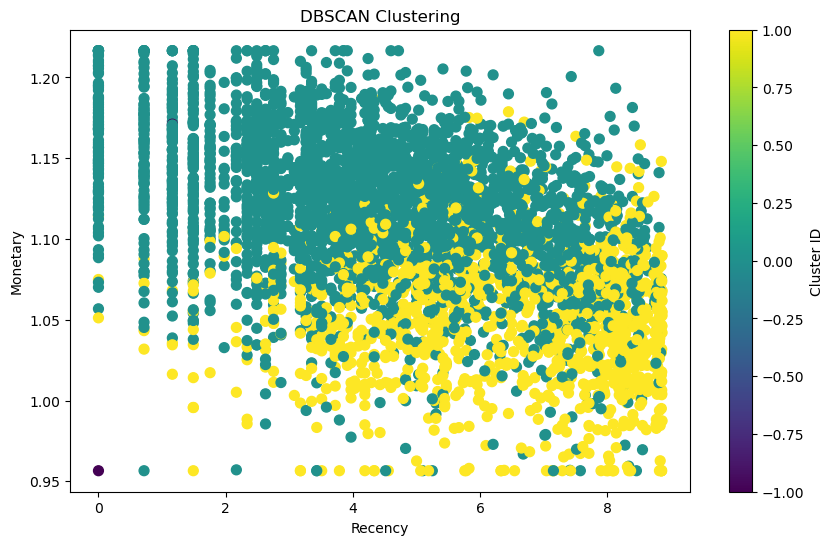

Number of clusters (excluding noise): 3
Number of noise points: 2


In [101]:
from sklearn.cluster import DBSCAN


# Apply DBSCAN for clustering
dbscan = DBSCAN(eps=0.2, min_samples=5)  
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(RFM_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(rfm['Recency'], rfm['Monetary'], c=rfm['DBSCAN_Cluster'], cmap='viridis', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.colorbar(label='Cluster ID')
plt.show()

# Evaluate the number of clusters (ignoring noise points labeled as -1)
num_clusters = len(set(rfm['DBSCAN_Cluster'])) - (1 if -1 in rfm['DBSCAN_Cluster'] else 0)
num_noise_points = list(rfm['DBSCAN_Cluster']).count(-1)

print(f"Number of clusters (excluding noise): {num_clusters}")
print(f"Number of noise points: {num_noise_points}")


**This is generally a good result:**

**3 clusters:** The fact that DBSCAN has identified 3 separate groups as needed

**2 noise points:** It's normal to have a few noise points, especially if someone have outliers or extreme values in data. 

# Visualizations

In [104]:
from sklearn.manifold import TSNE


def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    # Fit KMeans model
    kmeans = KMeans(n_clusters=clusters_number, random_state=42)
    kmeans.fit(normalised_df_rfm)
    cluster_labels = kmeans.labels_

    df_new = original_df_rfm.copy() 
    df_new['Cluster'] = cluster_labels
    
    # Initialise TSNE model for dimensionality reduction
    model = TSNE(random_state=42)
    transformed = model.fit_transform(df_new[['Recency', 'Frequency', 'Monetary']])
    
    # Plot t-SNE with clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], hue=cluster_labels, 
                    style=cluster_labels, palette="Set1", s=100, edgecolor='black')
    plt.title(f'T-SNE visualization of {clusters_number} Clusters')
    plt.legend(title='Cluster', loc='upper right')
    plt.show()
    
    return df_new




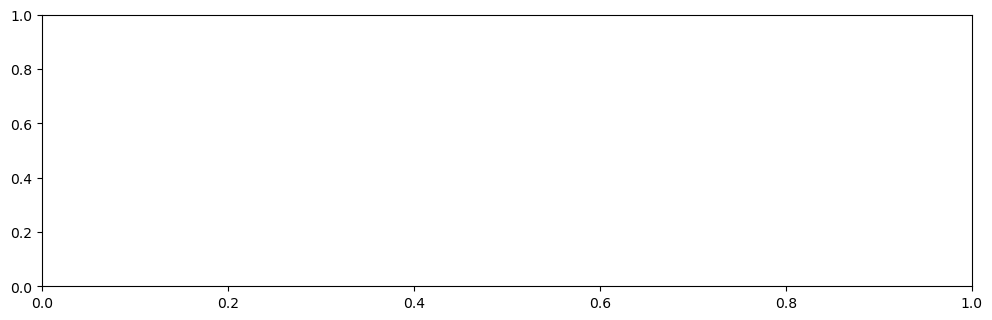

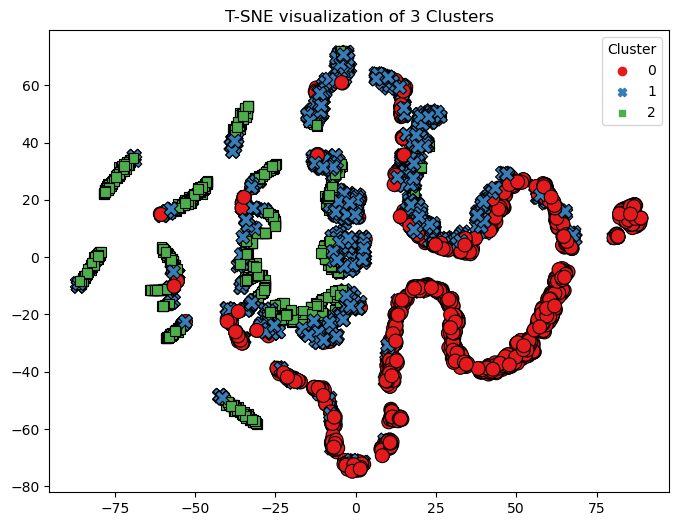

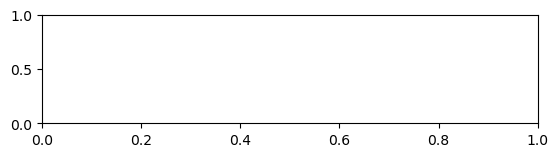

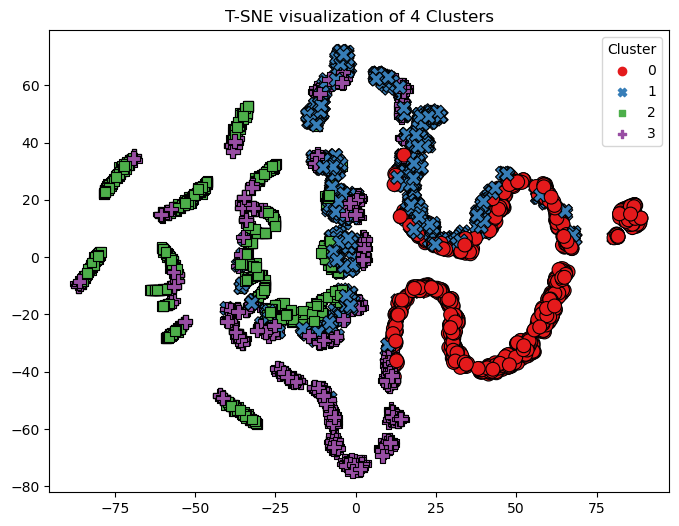

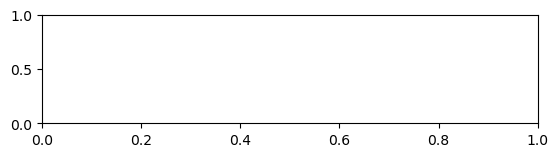

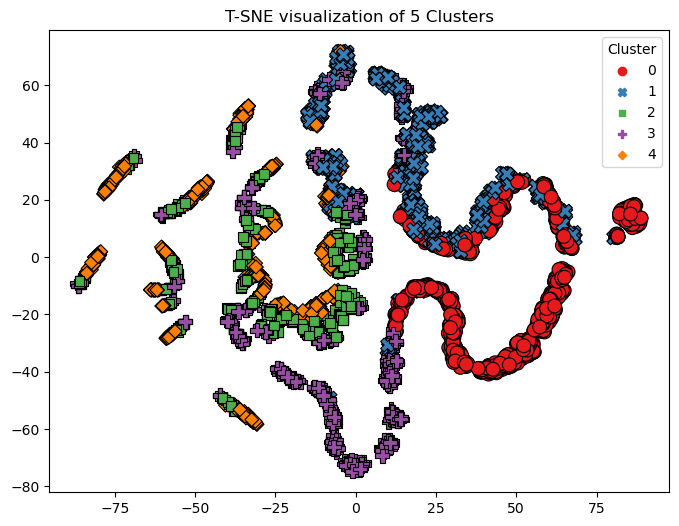

<Figure size 640x480 with 0 Axes>

In [105]:
# Create subplots for KMeans clustering with different number of clusters (3, 4, 5)
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_scaled, 3, rfm)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_scaled, 4, rfm)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_scaled, 5, rfm)

plt.tight_layout()

I have seen TSNE 3D plot but I can't uderstand it, let's try for PCA to convert into 2D



# PCA Plot

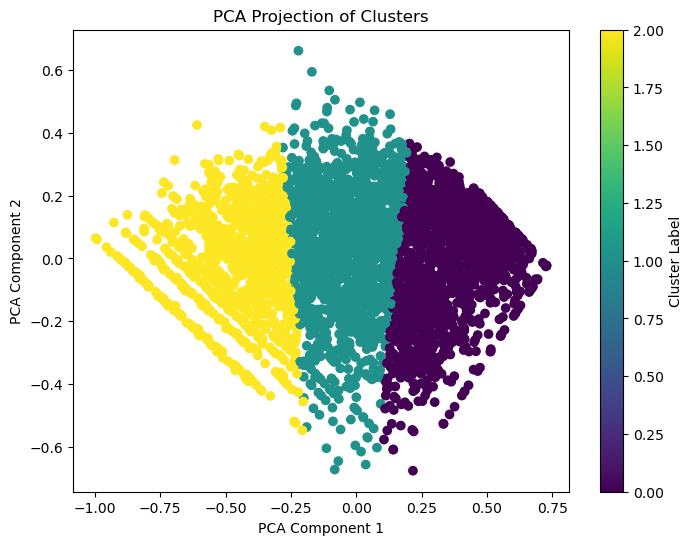

In [112]:
from sklearn.decomposition import PCA
# Assume kmeans is already fitted with labels
kmeans = KMeans(n_clusters=3, random_state=42)  # Example of kmeans fitting
kmeans.fit(RFM_scaled)  # Use the scaled RFM data


# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(RFM_scaled)

cluster_labels = kmeans.labels_
# Plot the 2D PCA projection with cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('PCA Projection of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


**If looking for engaged customers: K=3, Cluster 2 appears promising.**

**For high-value but infrequent shoppers: K=4, Cluster 3 stands out.**

**For high-frequency, high-spending customers: K=5, Cluster 4 is an optimal choice.**

**The best cluster for targeting or analysis will depend on specific business goals!**

In [118]:
def rfm_values(df):

    # Grouping by 'Cluster' and calculating mean for 'Recency', 'Frequency', and 'Monetary', and count for 'Monetary'
    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return df_new

# Call the function with df_rfm_k3 (or any other cluster data you want to analyze)
rfm_values(df_rfm_k5)


Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0           8.0       0.0      1.0   969
1           6.0       1.0      1.0   983
2           3.0       1.0      1.0   821
3           4.0       0.0      1.0   820
4           2.0       1.0      1.0   729

# What does Cluster Represent:
**Cluster 0 and Cluster 3**: These clusters may represent inactive or low-engagement customers.

**Cluster 1 and Cluster 4**: These clusters may represent semi-active or recently engaged customers, and they might be targeted for promotions or re-engagement efforts.

**Cluster 2**: This group is active but low-spending. You might want to focus on increasing their spending.

# Summary
**Customer Segmentation**: The project successfully segmented the customer base into meaningful groups, providing insights into customer behavior and engagement.

**Marketing Strategies**: Based on the cluster characteristics, personalized marketing campaigns can be designed for different segments, including re-engagement offers for inactive customers and loyalty rewards for active but low-spending customers.

By leveraging clustering techniques like K-Means and DBSCAN, the project demonstrates how customer segmentation can be used to enhance marketing efforts, optimize customer engagement, and improve overall business performance.